## 畳み込みニューラルネットワークの実践
## AIF_sprint13_cnn2
この課題の目的  
・スクラッチを通してCNNの基礎を理解する   
・基本的なCNNのキーワードを学習する   
・初期の有名なCNNモデルを知る   

【目的としないこと】   
実用的なCNNモデルに関する知識の習得

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata

# MNISTの読み込み
mnist_dir = "/Users/andoutakaaki/DIC_study/sprint9/mnist_data/"
mnist = fetch_mldata('MNIST original', data_home=mnist_dir)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.2)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# 正解（ラベル）をint型にしておく
y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)
y_val = y_val.astype(np.int)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_val = X_val.astype(np.float)
X_train /= 255
X_test /= 255
X_val /= 255

# -- 正解をone-hot表現に --
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])
y_val = enc.transform(y_val[:, np.newaxis])

# 28×28に変形
# チャンネル方向の軸は用意:(n_samples, n_channels, height, width)のNCHW
X_train = X_train.reshape(44800,1, 28,28)
X_test = X_test.reshape(14000,1, 28,28)
X_val = X_val.reshape(11200,1, 28,28)

n_train = X_train.shape[0]  # 訓練データのサンプル数
n_test = X_test.shape[0]  # テストデータのサンプル数
n_val = X_val.shape[0]  # valデータのサンプル数

print(X_train.shape,X_test.shape,X_val.shape)
print(y_train,y_test.shape,y_val)

(44800, 1, 28, 28) (14000, 1, 28, 28) (11200, 1, 28, 28)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (14000, 10) [[0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [2]:
# -- 各設定値 --
img_h = 28  # 入力画像の高さ
img_w = 28  # 入力画像の幅
img_ch = 1  # 入力画像のチャンネル数

wb_width = 0.1  # 重みとバイアスの広がり具合
eta = 0.01  # 学習係数
epoch = 10
batch_size = 1
interval = 10  # 経過の表示間隔
n_sample = 44800  # 誤差計測のサンプル数


In [3]:
# -- im2col --
def im2col(images, flt_h, flt_w, out_h, out_w, stride, pad):
   
    n_bt, n_ch, img_h, img_w = images.shape
    
    img_pad = np.pad(images, [(0,0), (0,0), (pad, pad), (pad, pad)], "constant")
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))

    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            cols[:, :, h, w, :, :] = img_pad[:, :, h:h_lim:stride, w:w_lim:stride]

    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(n_ch*flt_h*flt_w, n_bt*out_h*out_w)
    return cols

In [4]:
# -- col2im --
def col2im(cols, img_shape, flt_h, flt_w, out_h, out_w, stride, pad):
 
    n_bt, n_ch, img_h, img_w = img_shape
    
    cols = cols.reshape(n_ch, flt_h, flt_w, n_bt, out_h, out_w, ).transpose(3, 0, 1, 2, 4, 5)
    images = np.zeros((n_bt, n_ch, img_h+2*pad+stride-1, img_w+2*pad+stride-1))
    
    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            images[:, :, h:h_lim:stride, w:w_lim:stride] += cols[:, :, h, w, :, :]

    return images[:, :, pad:img_h+pad, pad:img_w+pad]


In [5]:
# -- 畳み込み層 --
class ConvLayer:
    
    # n_bt:バッチサイズ, x_ch:入力チャンネル数, x_h:入力画像高さ, x_w:入力画像幅
    # n_flt:フィルタ数, flt_h:フィルタ高さ, flt_w:フィルタ幅
    # stride:ストライド幅, pad:パディング幅
    # y_ch:出力チャンネル数, y_h:出力高さ, y_w:出力幅
    
    def __init__(self, x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad):

        # パラメータをまとめる
        self.params = (x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad)
        
        # フィルタとバイアスの初期値
        self.w = wb_width * np.random.randn(n_flt, x_ch, flt_h, flt_w)
        self.b = wb_width * np.random.randn(1, n_flt)
        
        # 出力画像のサイズ
        self.y_ch = n_flt  # 出力チャンネル数
        self.y_h = (x_h - flt_h + 2*pad) // stride + 1  # 出力高さ
        self.y_w = (x_w - flt_w + 2*pad) // stride + 1  # 出力幅
 
        # AdaGrad用
        self.h_w = np.zeros((n_flt, x_ch, flt_h, flt_w)) + 1e-8
        self.h_b = np.zeros((1, n_flt)) + 1e-8
        
    def forward(self, x):
        n_bt = x.shape[0] 
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 入力画像とフィルタを行列に変換
        self.cols = im2col(x, flt_h, flt_w, y_h, y_w, stride, pad)
        self.w_col = self.w.reshape(n_flt, x_ch*flt_h*flt_w)
        
        # 出力の計算: 行列積、バイアスの加算、活性化関数
        u = np.dot(self.w_col, self.cols).T + self.b
        self.u = u.reshape(n_bt, y_h, y_w, y_ch).transpose(0, 3, 1, 2)
        self.y = np.where(self.u <= 0, 0, self.u)
    
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # delta
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        delta = delta.transpose(0,2,3,1).reshape(n_bt*y_h*y_w, y_ch)
        
        # フィルタとバイアスの勾配
        grad_w = np.dot(self.cols, delta)
        self.grad_w = grad_w.T.reshape(n_flt, x_ch, flt_h, flt_w)
        self.grad_b = np.sum(delta, axis=0)
        
        # 入力の勾配
        grad_cols = np.dot(delta, self.w_col)
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols.T, x_shape, flt_h, flt_w, y_h, y_w, stride, pad)
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

In [6]:
# -- プーリング層 --
class PoolingLayer:
    
    # n_bt:バッチサイズ, x_ch:入力チャンネル数, x_h:入力画像高さ, x_w:入力画像幅
    # pool:プーリング領域のサイズ, pad:パディング幅
    # y_ch:出力チャンネル数, y_h:出力高さ, y_w:出力幅
    
    def __init__(self, x_ch, x_h, x_w, pool, pad):
        
        # パラメータをまとめる
        self.params = (x_ch, x_h, x_w, pool, pad)
        
        # 出力画像のサイズ
        self.y_ch = x_ch  # 出力チャンネル数
        self.y_h = x_h//pool if x_h%pool==0 else x_h//pool+1  # 出力高さ
        self.y_w = x_w//pool if x_w%pool==0 else x_w//pool+1  # 出力幅
        
    def forward(self, x):
        n_bt = x.shape[0] 
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 入力画像を行列に変換
        cols = im2col(x, pool, pool, y_h, y_w, pool, pad)
        cols = cols.T.reshape(n_bt*y_h*y_w*x_ch, pool*pool)
        
        # 出力の計算: Maxプーリング
        y = np.max(cols, axis=1)
        self.y = y.reshape(n_bt, y_h, y_w, x_ch).transpose(0, 3, 1, 2)
        
        # 最大値のインデックスを保存
        self.max_index = np.argmax(cols, axis=1)
    
    def backward(self, grad_y):
        n_bt = grad_y.shape[0] 
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 出力の勾配の軸を入れ替え
        grad_y = grad_y.transpose(0, 2, 3, 1)
        
        # 行列を作成し、各列の最大値であった要素にのみ出力の勾配を入れる
        grad_cols = np.zeros((pool*pool, grad_y.size))
        grad_cols[self.max_index.reshape(-1), np.arange(grad_y.size)] = grad_y.reshape(-1) 
        grad_cols = grad_cols.reshape(pool, pool, n_bt, y_h, y_w, y_ch)
        grad_cols = grad_cols.transpose(5,0,1,2,3,4) 
        grad_cols = grad_cols.reshape( y_ch*pool*pool, n_bt*y_h*y_w)

        # 入力の勾配
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols, x_shape, pool, pool, y_h, y_w, pool, pad)

In [7]:
# -- 全結合層の継承元 --
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)

        self.h_w = np.zeros(( n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
        

In [8]:
# -- 全結合 中間層 --
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 

In [9]:
# -- 全結合 出力層 --
class OutputLayer(BaseLayer):     
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1).reshape(-1, 1)

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 

In [10]:
# -- 各層の初期化 --
cl_1 = ConvLayer(img_ch, img_h, img_w, 10, 3, 3, 1, 1)
pl_1 = PoolingLayer(cl_1.y_ch, cl_1.y_h, cl_1.y_w, 2, 0)

n_fc_in = pl_1.y_ch * pl_1.y_h * pl_1.y_w
ml_1 = MiddleLayer(n_fc_in, 100)
ol_1 = OutputLayer(100, 10)

In [11]:
# -- 順伝播 --
def forward_propagation(x):
    n_bt = x.shape[0]
    
    images = x.reshape(n_bt, img_ch, img_h, img_w)
    cl_1.forward(images)
    pl_1.forward(cl_1.y)
    
    fc_input = pl_1.y.reshape(n_bt, -1)   
    ml_1.forward(fc_input)
    ol_1.forward(ml_1.y)


In [12]:
# -- 逆伝播 --
def backpropagation(t):
    n_bt = t.shape[0]
    
    ol_1.backward(t)
    ml_1.backward(ol_1.grad_x)
    
    grad_img = ml_1.grad_x.reshape(n_bt, pl_1.y_ch, pl_1.y_h, pl_1.y_w)
    pl_1.backward(grad_img)
    cl_1.backward(pl_1.grad_x)


In [13]:
# -- 重みとバイアスの更新 --
def uppdate_wb():
    cl_1.update(eta)
    ml_1.update(eta)
    ol_1.update(eta)

# -- 誤差を計算 --
def get_error(t, batch_size):
    return -np.sum(t * np.log(ol_1.y + 1e-7)) / batch_size # 交差エントロピー誤差


In [14]:
# -- サンプルを順伝播 --
def forward_sample(inp, correct, n_sample):
    index_rand = np.arange(len(correct))
    np.random.shuffle(index_rand) 
    index_rand = index_rand[:n_sample]
    x = inp[index_rand, :]
    t = correct[index_rand, :]
    forward_propagation(x)
    return x, t


In [15]:
# -- 誤差の記録用 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

# -- 学習と経過の記録 --
n_batch = n_train // batch_size
for i in range(epoch):

    # -- 誤差の計測 -- 
    x, t = forward_sample(X_train, y_train, n_sample)
    error_train = get_error(t, n_sample)
    
    x, t = forward_sample(X_test, y_test, n_sample) 
    error_test = get_error(t, n_sample)
    
    # -- 誤差の記録 -- 
    train_error_x.append(i)
    train_error_y.append(error_train) 
    test_error_x.append(i)
    test_error_y.append(error_test) 
    
    # -- 経過の表示 --
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:" + str(error_test))
        
        # -- 学習 -- 
    index_rand = np.arange(n_train)
    np.random.shuffle(index_rand)   
    for j in range(n_batch):
        
        mb_index = index_rand[j*batch_size : (j+1)*batch_size]
        x = X_train[mb_index, :]
        t = y_train[mb_index, :]

        forward_propagation(x)
        backpropagation(t)        
        uppdate_wb() 
            

Epoch:0/10 Error_train:2.3526994692760317 Error_test:0.73578834791586


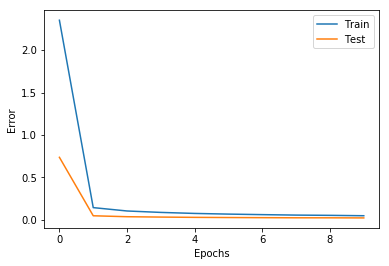

Accuracy Train: 98.80580357142857% Accuracy Test: 98.14285714285714%


In [16]:
# -- 誤差の記録をグラフ表示 -- 
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 正解率の測定 -- 
x, t = forward_sample(X_train, y_train, n_train) 
count_train = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

x, t = forward_sample(X_test, y_test, n_test) 
count_test = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")

### 畳み込み層とは何か
畳み込みは、画像処理の分野ではポピュラーな演算であり、画像に対して畳み込みを行うことで、画像のある特徴を強めたり、弱めたりすることができる。   
畳み込み層では、この畳み込み処理により入力画像をより特徴が強調されたものに変換する。    
また、画像には局所性という性質がある。局所性とは、各ピクセルが近傍のピクセルと強い関連性を持っている性質のことである。例えば、ある隣り合ったピクセル同士は似たような色になる可能性が高いし、複数のピクセルからなるかたまりが物体の輪郭を構成することもある。畳み込み層は、このような画像の局所性を利用して画像の特徴を検出する。


### プーリング層とは何か
プーリング層は通常、畳み込み層の直後に配置される。プーリング層では画像を各領域に区切り、各領域を代表する値を抽出し並べて新たな画像とする。このような処理をプーリングという。      
プーリングの代表的な方法として、各領域の最大値を各領域の代表とする値とするMAXプーリングが使われることが多い。   
プーリングは言わば画像をぼかす処理なので、対象の位置の感度が低下する。これにより、対象の位置が多少変化しても、結果は同じようになる。また、プーリングにより画像サイズが小さくなるので、計算量が削減される効果もある。     
プーリング層で区切る領域は固定であり、学習するパラメータがないので学習は行われない。また、チャンネルが合流したり分岐したりすることはないので、入力のチャンネル数と出力のチャンネル数は同じになる。

### CNNは全結合層のみのニューラルネットワークとどのように違うか
ノードからノードに全て結合するのが全結合であり、全てでない手抜きが非全結合である。全結合層のみのニューラルネットワークで計算すると処理が膨大になってしまう。このため、畳み込み層やプーリング層では、非全結合で処理することにより、大幅に計算を削減することができる。    
また、全結合層の問題点として、形状を無視して、すべての入力データを同じ次元のニューロンとして扱うので、形状に関する情報を生かすことができない。一方で、折り畳み層は形状を維持するため、CNNでは、画像などの形状を有したデータを正しく理解することができる。

### 出力サイズとパラメータ数の計算
1. 出力サイズ　142×142=20,164、パラメータ数　142×142×3×6=362,952      
2. 出力サイズ　58×58=3,364、    パラメータ数　58×58×24×48=3,875,328      
2. 出力サイズ　10×10=100、    パラメータ数　10×10×10×20=20,000

### フィルタサイズ
#### 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由 
例えば、５×５などの大きめのものに比べて、畳み込みの操作を、3×3のフィルタにより連続した畳み込み演算で置き換えることによって、より少ないパラメータ数で実現できる。    
また、3×3畳み込みは、２×２畳み込みよりも、パラメータ数が削減されることが分かっており、一般的には3×3のフィルタが使われている。
#### 高さや幅方向を持たない1×1のフィルタの効果   
1×1のフィルタは、チャンネル方向には画素数を加算するので、非自明な作用をする。また、フィルタのチャネル数を元画像よりも少なくしておくことで、返還後の画像のチャネル数削減が行える。    
さらに、サイズの大きなデータの畳み込み演算は計算量がかさむため、中間層で次元削減をすることで計算にかかるコストを下げたい場合に、この1×1畳み込みが利用される。

### 1次元と2次元畳み込みの違い
1次元畳み込みは、時系列データ、つまりグラフを用いて、その中にパターンを見つけ、時系列データの特徴を捉える。     
一方で、2次元畳み込は、画像の特徴を表すパターンを抽出する。